## Get mounted data

In [13]:
from google.colab import drive
import os
drive.mount('/content/drive/')
save_path = '/content/drive/MyDrive/nlu'
os.makedirs(save_path, exist_ok=True)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Imports

In [14]:
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Dot, Softmax, Reshape, Permute,
    Concatenate, GlobalAveragePooling1D, GlobalMaxPooling1D,
    Lambda, BatchNormalization, LSTM, Bidirectional
)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from transformers import TFAutoModel, AutoTokenizer

from tensorflow.keras.models import load_model
from keras import config as keras_config
from keras.saving import register_keras_serializable

import nltk
from nltk.corpus import wordnet
import random
import csv

nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Hyperparameters

In [15]:
MODEL_NAME = 'microsoft/deberta-v3-base'
MAX_SEQUENCE_LENGTH = 128
HIDDEN_SIZE = 512
NUM_CLASSES = 2
BATCH_SIZE = 32
EPOCHS = 15
DROPOUT_RATE = 0.3

## Model Architecture and Creating Model

In [16]:
def create_decomposable_attention_model(transformer_model, hidden_dim, dropout_rate, max_seq_length, num_classes=2):

    # Define inputs
    input_ids = Input(shape=(max_seq_length,), dtype='int32', name='input_ids')
    attention_mask = Input(shape=(max_seq_length,), dtype='int32', name='attention_mask')
    token_type_ids = Input(shape=(max_seq_length,), dtype='int32', name='token_type_ids')

    # Convert attention_mask to float32
    @keras.saving.register_keras_serializable()
    def cast_to_float(x):
      return tf.cast(x, tf.float32)

    attention_mask_float = Lambda(cast_to_float)(attention_mask)

    # Method to handle the transformer model call in sequence_output layer
    @keras.saving.register_keras_serializable()
    def get_transformer_embeddings(inputs):
        return transformer_model(
            input_ids=inputs[0],
            attention_mask=inputs[1],
            token_type_ids=inputs[2]
        )[0]

    embedding_dim = transformer_model.config.hidden_size

    # Get transformer embeddings
    sequence_output = Lambda(
        get_transformer_embeddings,
        output_shape=(max_seq_length, embedding_dim)
    )([input_ids, attention_mask, token_type_ids])

    # Split premise and hypothesis with token_type_ids
    @register_keras_serializable()
    def cast_to_float0(x):
      return tf.cast(tf.equal(x, 0), tf.float32)

    @register_keras_serializable()
    def cast_to_float1(x):
      return tf.cast(tf.equal(x, 1), tf.float32)

    premise_mask = Lambda(cast_to_float0)(token_type_ids)
    hypothesis_mask = Lambda(cast_to_float1)(token_type_ids)

    @register_keras_serializable()
    def multiply_pair(x):
        return x[0] * x[1]

    # Include the attention mask
    premise_mask = Lambda(multiply_pair)([premise_mask, attention_mask_float])
    hypothesis_mask = Lambda(multiply_pair)([hypothesis_mask, attention_mask_float])

    @register_keras_serializable()
    def expand_last_dim(x):
        return tf.expand_dims(x, axis=-1)

    # Reshape masks
    premise_mask_expanded = Lambda(expand_last_dim)(premise_mask)
    hypothesis_mask_expanded = Lambda(expand_last_dim)(hypothesis_mask)

    # Extract premise and hypothesis embeddings
    premise_embedded = Lambda(multiply_pair)([sequence_output, premise_mask_expanded])
    hypothesis_embedded = Lambda(multiply_pair)([sequence_output, hypothesis_mask_expanded])

    # Encoding layer
    premise_encoded = Dense(hidden_dim, activation='tanh')(premise_embedded)
    premise_encoded = Dropout(dropout_rate)(premise_encoded)

    hypothesis_encoded = Dense(hidden_dim, activation='tanh')(hypothesis_embedded)
    hypothesis_encoded = Dropout(dropout_rate)(hypothesis_encoded)

    # Attention mechanism
    @register_keras_serializable()
    def compute_attention(inputs):
        p_enc, h_enc = inputs
        return tf.matmul(p_enc, tf.transpose(h_enc, perm=[0, 2, 1]))

    attention_scores = Lambda(compute_attention)([premise_encoded, hypothesis_encoded])

    # Apply softmax to get attention weights
    @register_keras_serializable()
    def apply_softmax_1(x):
        return tf.nn.softmax(x, axis=-1)
    @register_keras_serializable()
    def apply_softmax_2(x):
        return tf.nn.softmax(x, axis=1)

    premise_attention = Lambda(apply_softmax_1)(attention_scores)
    hypothesis_attention = Lambda(apply_softmax_2)(attention_scores)

    # Get attended vectors
    @register_keras_serializable()
    def get_attended_1(inputs):
        att, h_enc = inputs
        return tf.matmul(att, h_enc)
    @register_keras_serializable()
    def get_attended_2(inputs):
        att, p_enc = inputs
        return tf.matmul(tf.transpose(att, perm=[0, 2, 1]), p_enc)

    attended_hypothesis = Lambda(get_attended_1)([premise_attention, hypothesis_encoded])
    attended_premise = Lambda(get_attended_2)([hypothesis_attention, premise_encoded])

    # Combine original and attended vectors
    enhanced_premise = Concatenate()([premise_encoded, attended_hypothesis])
    enhanced_hypothesis = Concatenate()([hypothesis_encoded, attended_premise])

    # Compare step
    compared_premise = Dense(hidden_dim, activation='tanh')(enhanced_premise)
    compared_premise = Dropout(dropout_rate)(compared_premise)

    compared_hypothesis = Dense(hidden_dim, activation='tanh')(enhanced_hypothesis)
    compared_hypothesis = Dropout(dropout_rate)(compared_hypothesis)

    # Aggregate step
    @register_keras_serializable()
    def pooling_with_mask(inputs):
        compared, mask = inputs
        sum_values = tf.reduce_sum(compared * mask, axis=1)
        count = tf.reduce_sum(mask[:,:,0], axis=1, keepdims=True)
        return sum_values / (count + 1e-10)

    aggregated_premise = Lambda(pooling_with_mask)([compared_premise, premise_mask_expanded])
    aggregated_hypothesis = Lambda(pooling_with_mask)([compared_hypothesis, hypothesis_mask_expanded])

    # Combine aggregated vectors
    merged = Concatenate()([aggregated_premise, aggregated_hypothesis])

    # Final classification layers
    dense = Dense(hidden_dim, activation='tanh')(merged)
    dense = Dropout(dropout_rate)(dense)
    output = Dense(num_classes, activation='softmax')(dense)

    # Create model
    model = Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=output)

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
transformer_model = TFAutoModel.from_pretrained(MODEL_NAME, trainable=False)
model = create_decomposable_attention_model(
    transformer_model=transformer_model,
    hidden_dim=HIDDEN_SIZE,
    dropout_rate=DROPOUT_RATE,
    max_seq_length=MAX_SEQUENCE_LENGTH,
    num_classes=NUM_CLASSES
)

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
All model checkpoint layers were used when initializing TFDebertaV2Model.

All the layers of TFDebertaV2Model were initialized from the model checkpoint at microsoft/deberta-v3-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaV2Model for predictions without further training.


In [17]:
# Load model weights from file
keras_config.enable_unsafe_deserialization()
model.load_weights("/content/drive/MyDrive/nlu/attmodel/finalemodelB.weights.h5")

# Prepare data function
def prepare_deberta_data(data, tokenizer, max_length=128):
    # Encode premises
    premises = data['premise'].fillna('').astype(str).tolist()
    hypotheses = data['hypothesis'].fillna('').astype(str).tolist()

    # Tokenize inputs
    encoded = tokenizer(
        premises, hypotheses,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='np'
    )

    # Convert labels to one-hot encoding
    labels = to_categorical(data['label'].values, num_classes=2)
    print(labels.shape)
    return encoded, labels

# Load CSV
df = pd.read_csv('/content/drive/MyDrive/nlu/dev.csv')
df["label"] = df["label"].astype(int)

# Prepare test data
test_inputs, test_labels = prepare_deberta_data(df, tokenizer)
test_labels = np.argmax(test_labels, axis=1)  # If one-hot encoded

# Predict class probabilities
y_pred_probs = model.predict([
    test_inputs['input_ids'],
    test_inputs['attention_mask'],
    test_inputs['token_type_ids']
])

# Convert to predicted class
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_labels

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


(6736, 2)
211/211 ━━━━━━━━━━━━━━━━━━━━ 30s 113ms/step


#**Evaluation**

# Classification Metrics

In [18]:
from sklearn.metrics import classification_report
report_dict = classification_report(y_true, y_pred, output_dict=True)
overall_accuracy = report_dict.pop('accuracy')
report_df = pd.DataFrame(report_dict).transpose()
report_df = report_df.drop(columns=['support'])
print("Overall Accuracy:")
print(overall_accuracy)
print("\nClassification Report:")
print(report_df)

Overall Accuracy:
0.8712885985748219

Classification Report:
              precision    recall  f1-score
0              0.862822  0.872621  0.867694
1              0.879396  0.870040  0.874693
macro avg      0.871109  0.871331  0.871194
weighted avg   0.871380  0.871289  0.871308


# Confusion Matrix, ROC Curve, Precision-Recall Curve

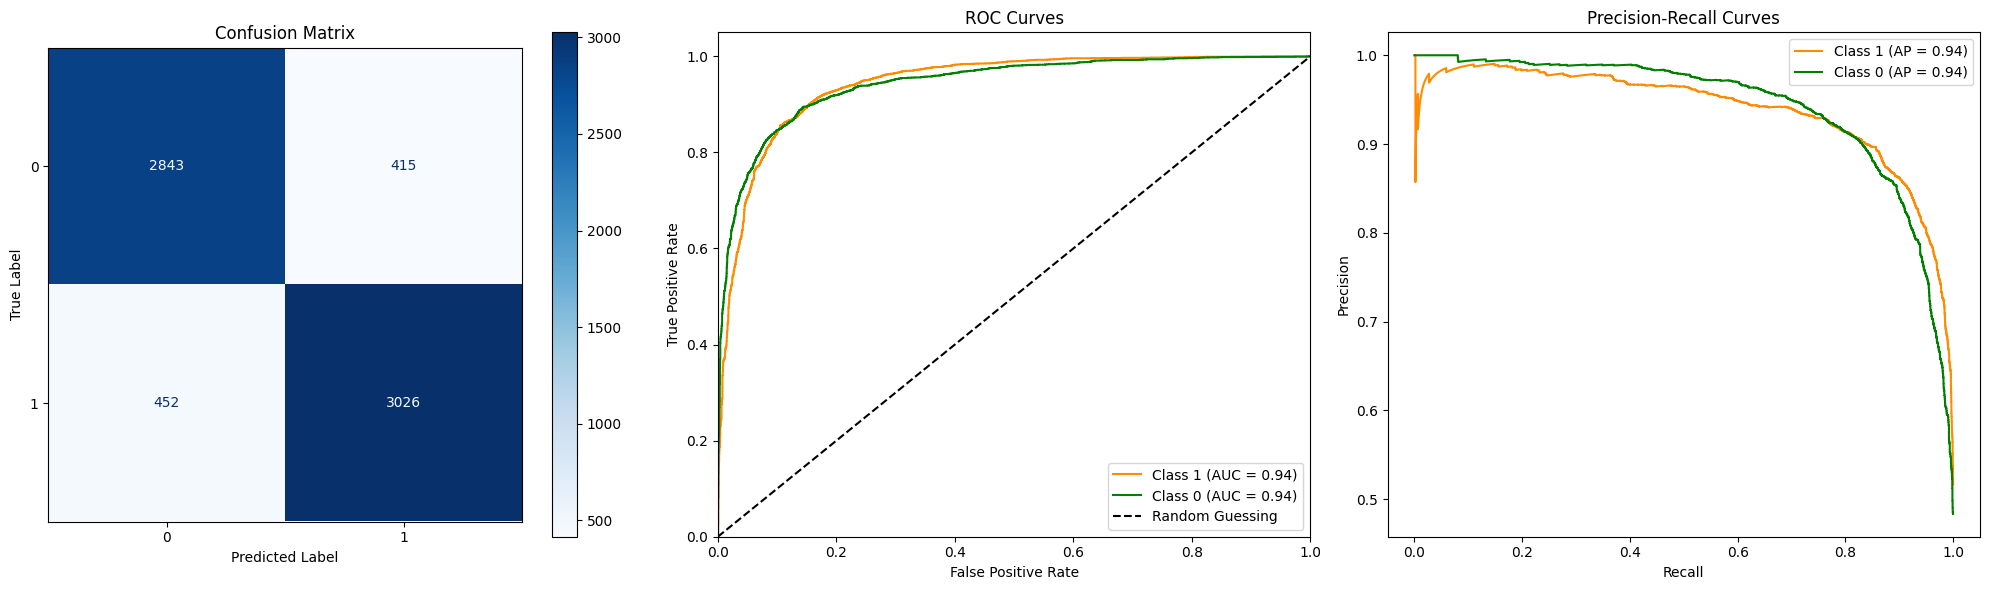

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# ---------------------------------
# Confusion Matrix
# ---------------------------------
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=axes[0], cmap=plt.cm.Blues)
axes[0].set_title("Confusion Matrix")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# ---------------------------------
# ROC Curves
# ---------------------------------
# Get predicted probabilities for each class
y_probs_class1 = y_pred_probs[:, 1]
y_probs_class0 = y_pred_probs[:, 0]

# Compute ROC curve and AUC for class 1
fpr1, tpr1, _ = roc_curve(y_true, y_probs_class1, pos_label=1)
roc_auc1 = auc(fpr1, tpr1)

# Compute ROC curve and AUC for class 0
fpr0, tpr0, _ = roc_curve(y_true, y_probs_class0, pos_label=0)
roc_auc0 = auc(fpr0, tpr0)

# Plot ROC curves
axes[1].plot(fpr1, tpr1, label=f'Class 1 (AUC = {roc_auc1:.2f})', color='darkorange')
axes[1].plot(fpr0, tpr0, label=f'Class 0 (AUC = {roc_auc0:.2f})', color='green')
axes[1].plot([0, 1], [0, 1], 'k--', label='Random Guessing')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves')
axes[1].legend(loc="lower right")

# ---------------------------------
# Precision-Recall Curves
# ---------------------------------
# For Class 1
precision1, recall1, _ = precision_recall_curve(y_true, y_probs_class1, pos_label=1)
avg_precision1 = average_precision_score(y_true, y_probs_class1)

# For Class 0
y_true_inverted = np.where(y_true == 0, 1, 0)
precision0, recall0, _ = precision_recall_curve(y_true_inverted, y_probs_class0)
avg_precision0 = average_precision_score(y_true_inverted, y_probs_class0)

# Plot Precision-Recall curves
axes[2].plot(recall1, precision1, label=f'Class 1 (AP = {avg_precision1:.2f})', color='darkorange')
axes[2].plot(recall0, precision0, label=f'Class 0 (AP = {avg_precision0:.2f})', color='green')
axes[2].set_xlabel('Recall')
axes[2].set_ylabel('Precision')
axes[2].set_title('Precision-Recall Curves')
axes[2].legend(loc="upper right")

# Display all plots in one row
plt.tight_layout()
plt.show()


# **Evaluation on Data Augmented Test Set**

### Create Augmented Data Set

In [20]:
# Load the CSV file directly with the right parameters
df = pd.read_csv('/content/drive/MyDrive/nlu/dev.csv', sep=',', quotechar='"',
                 names=['premise', 'hypothesis', 'label'], header=None)

# If the first row is the header, remove it
if df.iloc[0, 0] == 'premise':
    df = df.iloc[1:]

# Make sure the label column is numeric
df['label'] = pd.to_numeric(df['label'], errors='coerce')
df = df.dropna(subset=['label'])
df['label'] = df['label'].astype(int)

print("DataFrame loaded successfully:")
print(f"DataFrame shape: {df.shape}")
df.head()

DataFrame loaded successfully:
DataFrame shape: (6736, 3)


,premise,hypothesis,label
1,"By starting at the soft underbelly, the 16,000...","General Nelson A. Miles had 30,000 troops in h...",0
2,"The class had broken into a light sweat, but w...",The class grew more tense as time went on.,1
3,"Samson had his famous haircut here, but he wou...",It was unknown where exactly within the town S...,1
4,A man with a black shirt holds a baby while a ...,A darkly dressed man passes a crying baby to a...,0
5,I know that many of you are interested in addr...,The problems must be addressed,1


In [21]:
# Function to replace words with synonyms
def replace_with_synonyms(text, replace_probability=0.25):
    text = str(text).strip('"')

    words = nltk.word_tokenize(text)
    new_words = []

    for word in words:
        # Skip short words, punctuation, and common words
        if len(word) <= 3 or not word.isalpha() or word.lower() in ['the', 'and', 'but', 'for', 'nor', 'or', 'yet', 'so']:
            new_words.append(word)
            continue

        # Only replace with the given probability
        if random.random() > replace_probability:
            new_words.append(word)
            continue

        # Find synonyms
        synonyms = []
        for syn in wordnet.synsets(word):
            for lemma in syn.lemmas():
                synonym = lemma.name().replace('_', ' ')
                if synonym.lower() != word.lower():
                    synonyms.append(synonym)

        if synonyms:
            new_words.append(random.choice(synonyms))
        else:
            new_words.append(word)

    # Reconstruct the text
    result = ' '.join(new_words)

    # Capitalize first letter of sentences
    result = '. '.join(s.strip().capitalize() for s in result.split('. '))

    return result

# Create a list to hold ONLY the augmented examples
augmented_rows = []

# Add augmented samples
for idx, row in df.iterrows():
    # Create 1-2 augmented versions for each sample
    for _ in range(random.randint(1, 2)):
        new_row = row.copy()

        # Determine what to augment
        change_premise = random.random() < 0.7
        change_hypothesis = random.random() < 0.7

        if change_premise:
            new_row['premise'] = replace_with_synonyms(new_row['premise'])

        if change_hypothesis:
            new_row['hypothesis'] = replace_with_synonyms(new_row['hypothesis'])

        # Only add if something was changed
        if (new_row['premise'] != row['premise'] or
            new_row['hypothesis'] != row['hypothesis']):
            augmented_rows.append(new_row)

augmented_df = pd.DataFrame(augmented_rows)
augmented_df.to_csv('/content/drive/MyDrive/nlu/augmented_test_set_evalB.csv', index=False,
                   quoting=csv.QUOTE_NONNUMERIC)

print(f"Original dataset: {len(df)} samples")
print(f"Created {len(augmented_df)} augmented samples")

# Show sample of augmented data
print("\nSample of augmented data:")
augmented_df.head()

Original dataset: 6736 samples
Created 9169 augmented samples

Sample of augmented data:


,premise,hypothesis,label
1,"By starting at the soft underbelly , the 16,00...","General nelson a. Miles had 30,000 troops in h...",0
2,"The class had broken into a light sweat, but w...",The class grew to a greater extent tense as ti...,1
3,"Bruiser had his famed haircut here , but he wo...",It was unknown where exactly within the town S...,1
3,"Samson had his celebrated haircut here , but h...",It was unknown where exactly within the town S...,1
4,A man with a melanize shirt holds a baby while...,A darkly dressed man passes a crying baby to a...,0


### Load Model to Make Predictions on the Augmented Dataset

In [22]:
# Load CSV
df = pd.read_csv('/content/drive/MyDrive/nlu/augmented_test_set_evalB.csv')
df["label"] = df["label"].astype(int)

# Tokenize and encode
test_inputs, test_labels = prepare_deberta_data(df, tokenizer)
test_labels = np.argmax(test_labels, axis=1)  # If one-hot encoded
# Predict class probabilities
y_pred_probs = model.predict([
    test_inputs['input_ids'],
    test_inputs['attention_mask'],
    test_inputs['token_type_ids']
])

# Convert to predicted class
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_labels

(9169, 2)
287/287 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step


### Classification Report on Augmented Dataset

In [23]:
from sklearn.metrics import classification_report
report_dict = classification_report(y_true, y_pred, output_dict=True)
overall_accuracy = report_dict.pop('accuracy')
report_df = pd.DataFrame(report_dict).transpose()
report_df = report_df.drop(columns=['support'])
print("Overall Accuracy:")
print(overall_accuracy)
print("\nClassification Report:")
print(report_df)

Overall Accuracy:
0.8162285963572908

Classification Report:
              precision    recall  f1-score
0              0.798987  0.824585  0.811584
1              0.833153  0.808515  0.820649
macro avg      0.816070  0.816550  0.816117
weighted avg   0.816754  0.816229  0.816298
